# Example notebook for debugging your compression algorithm

This notebook shows how to import the functions from the `competition` folder, in case you want to debug using a notebook.
Remember that any code used in your entry needs to be in the `competition` folder, we will not run this notebook!

See the `README.md` for a description of how we will run your code.

In [2]:
""" This file contains the `encode` function. Feel free to split it into smaller functions """
import numpy as np
from typing import Tuple, Any
from cued_sf2_lab.jpeg import jpegenc
from jpeg_lbt import jpegXRenc
# from common import HeaderType, jpeg_quant_size, jpeg2000_quant_size, n_level
from scipy.optimize import fsolve, minimize
from cued_sf2_lab.jpeg import HuffmanTable
from cued_sf2_lab.laplacian_pyramid import quant1, quant2, quantise, bpp
HeaderType = Tuple[HuffmanTable, float]
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
import matplotlib.pyplot as plt



n_level = 4
jpeg2000_quant_size = 18.03030303030303
def header_bits(header: HeaderType) -> int:
    """ Estimate the number of bits in your header.
    
    If you have no header, return `0`. """
    # replace this with your size estimate, and a comment explaining how you got it!

    huffcode, min_step = header
    return (len(huffcode.bits) + len(huffcode.huffval)) * 8 + 64 #float size for min step


def encode(X: np.ndarray) -> Tuple[np.ndarray, HeaderType]:
    """
    Parameters:
        X: the input grayscale image
    
    Outputs:
        vlc: the variable-length codes
        header: any additional parameters to be saved alongside the image
    """
    # replace this with your chosen encoding scheme. If you do not use a header,
    # then `return vlc, None`.
    X_normalised = X - 128.0
    min_step = fsolve(bit_diff, x0 = jpeg2000_quant_size, args = (X_normalised))[0]
    min_step = np.float64(min_step)
    vlc, hufftab = jpegXRenc(X_normalised, n_level, min_step, opthuff=True, dcbits=8)
    return vlc, (hufftab, min_step)

def bit_diff(qstep: float, img: np.ndarray) -> float:
    target_bits = 40960 - 1424  - 64  # using opthuff, need to subtract 1424 to transmit table

    vlc, hufftab = jpegXRenc(img, n_level, qstep, opthuff=True, dcbits= 9)
    total_bits = sum(vlc[:, 1])
    tbit_diff = np.abs(target_bits - total_bits)

    return tbit_diff

In [3]:
""" This file contains the `decode` function. Feel free to split it into smaller functions """
import numpy as np
from cued_sf2_lab.jpeg import jpegdec
from typing import Tuple, Any


from jpeg_lbt import jpegXRdec
# from common import my_function, HeaderType, jpeg_quant_size, jpeg2000_quant_size, n_level
from cued_sf2_lab.jpeg import HuffmanTable
HeaderType = Tuple[HuffmanTable, float]

n_level = 4
jpeg2000_quant_size = 18.03030303030303
def decode(vlc: np.ndarray, header: HeaderType) -> np.ndarray:
    """
    Parameters:
        X: the input grayscale image
    
    Outputs:
        vlc: the variable-length codes
        header: any additional parameters to be saved alongside the image
    """
    # replace this with your chosen decoding scheme

    hufftab, min_step = header
    Z =  jpegXRdec(vlc, 4, min_step, hufftab=hufftab, dcbits=8)
    Z += 128.0
    return Z

In [4]:
N = 8
def rms_diff(qstep, X):
    target_RMS = 4.94399555858676
    vlc, _ = jpegXRenc(X, qstep, N, N, log=False, dcbits= 16)
    Z = jpegXRdec(vlc, qstep, N, N, log=False, dcbits = 16)

    return np.abs(target_RMS - np.std(X - Z))

In [5]:
X, _ = load_mat_img('lighthouse.mat', img_info='X')
target_RMS = np.std(X - quantise(X, 17))
ref = bpp(quantise(X, 17))*X.size
optimal_step = fsolve(rms_diff, x0 = 15, args = (X))[0]

/var/folders/72/h4v6qzl52g77p5x7841mw5480000gn/T/ipykernel_73969/969730399.py:4: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  optimal_step = fsolve(rms_diff, x0 = 15, args = (X))[0]


RMS error for normal: 28.738643259086118
comresstion ratios for normal: 2.1729544265710588


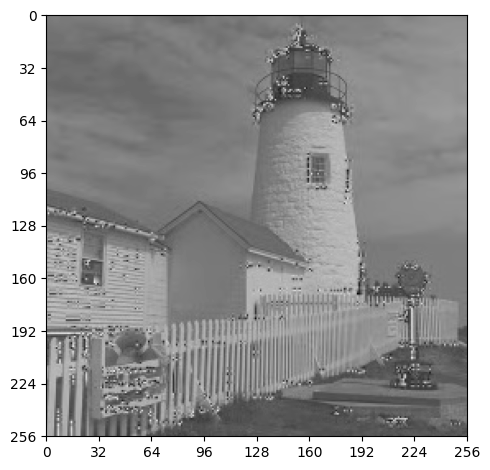

In [6]:
vlc_norm, _ = jpegXRenc(X, optimal_step, N, N, opthuff=False, log = False, dcbits=11)
Z_norm = jpegXRdec(vlc_norm, optimal_step, N, N, log=False, dcbits=11)

print("RMS error for normal: {}".format(np.std(X - Z_norm)))
print("comresstion ratios for normal: {}".format(ref/sum(vlc_norm[:,1])))


fig, ax = plt.subplots()
fig.tight_layout()
plot_image(Z_norm, ax=ax)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm, dct_ii, regroup
from cued_sf2_lab.dwt import dwt, idwt
from cued_sf2_lab.laplacian_pyramid import quant1, quant2, quantise, bpp
from cued_sf2_lab.jpeg import diagscan, runampl, huffdes, huffenc, huffgen, huffdflt, dwtgroup, HuffmanTable
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from scipy.optimize import fsolve, minimize
import numpy as np
import matplotlib.pyplot as plt
ref = bpp(quantise(X, 17))*X.size
n = 4
suffecient_step = 1
compression_ratio_mse = ref/(sum(vlc[:, 1]) + 1424)
print("suffecient mse step: {}".format(suffecient_step))
print(ref)
print("No. of bits for mse: {}".format(sum(vlc[:, 1]) + 1424))
print("RMS error for mse: {}".format(np.std(X - Z)))
print("Compression ratios for mse: {}".format(compression_ratio_mse))

suffecient mse step: 1
228783.85271038706
No. of bits for mse: 40640
RMS error for mse: 7.918993143459464
Compression ratios for mse: 5.629523934802831
